In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import scipy
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
import spacy
from nltk.corpus import state_union, stopwords
from collections import Counter

## Bag of words (BoW)

In [5]:
# Grab first speech given by Clinton and Kennedy
clinton = state_union.raw('1993-Clinton.txt')
kennedy = state_union.raw('1961-Kennedy.txt')

In [6]:
# Parse using SpaCy
nlp = spacy.load('en_core_web_sm')
clinton_doc = nlp(clinton)
kennedy_doc = nlp(kennedy)

In [8]:
# Group into sentences
clinton_sents = [[sent, 'Clinton'] for sent in clinton_doc.sents]
kennedy_sents = [[sent, 'Kennedy'] for sent in kennedy_doc.sents]

# Combine
sentences = pd.DataFrame(clinton_sents + kennedy_sents)
sentences.head()

,0,1
0,"(PRESIDENT, BILL, CLINTON, 'S, ADDRESS, BEFORE...",Clinton
1,"(Mr., President, ,, Mr., Speaker, ,, Members, ...",Clinton
2,"(It, is, nice, to, have, a, fresh, excuse, for...",Clinton
3,"([, Laughter, ], \n)",Clinton
4,"(When, Presidents, speak, to, Congress, and, t...",Clinton


In [10]:
# Look at excerpts from each 
print(clinton_doc[:100])
print('\n', kennedy_doc[:100])

PRESIDENT BILL CLINTON'S ADDRESS BEFORE A JOINT SESSION OF THE CONGRESS ON THE STATE OF THE UNION
 
February 17, 1993 

Mr. President, Mr. Speaker, Members of the House and the Senate, distinguished Americans here as visitors in this Chamber, as am I. It is nice to have a fresh excuse for giving a long speech. [Laughter]
When Presidents speak to Congress and the Nation from this podium, typically they comment on the full range and challenges and opportunities that face the United States. But this is

 PRESIDENT JOHN F. KENNEDY'S SPECIAL MESSAGE TO THE CONGRESS ON URGENT NATIONAL NEEDS
 
May 25, 1961

Mr. Speaker, Mr. Vice President, my copartners in Government, gentlemen-and ladies:
The Constitution imposes upon me the obligation to "from time to time give to the Congress information of the State of the Union." While this has traditionally been interpreted as an annual affair, this tradition has been broken in extraordinary times.
These are extraordinary times. And we face an extraordi

In [14]:
# Utility function to create a list of the 2000 most common words.
def bag_of_words(text):
    
    # Filter out punctuation and stop words.
    allwords = [token.lemma_
                for token in text
                if not token.is_punct
                and not token.is_stop]
    
    # Return the most common words.
    return [item[0] for item in Counter(allwords).most_common(2000)]
    

# Creates a data frame with features for each word in our common word set.
# Each value is the count of the times the word appears in each sentence.
def bow_features(sentences, common_words):
    
    # Scaffold the data frame and initialize counts to zero.
    df = pd.DataFrame(columns=common_words)
    df['text_sentence'] = sentences[0]
    df['text_source'] = sentences[1]
    df.loc[:, common_words] = 0
    
    # Process each row, counting the occurrence of words in each sentence.
    for i, sentence in enumerate(df['text_sentence']):
        
        # Convert the sentence to lemmas, then filter out punctuation,
        # stop words, and uncommon words.
        words = [token.lemma_
                 for token in sentence
                 if (
                     not token.is_punct
                     and not token.is_stop
                     and token.lemma_ in common_words
                 )]
        
        # Populate the row with word counts.
        for word in words:
            df.loc[i, word] += 1
        
        # This counter is just to make sure the kernel didn't hang.
        if i % 100 == 0:
            print("Processing row {}".format(i))
            
    return df

# Set up the bags.
clinton_words = bag_of_words(clinton_doc)
kennedy_words = bag_of_words(kennedy_doc)

# Combine bags to create common set of unique words
common_words = set(clinton_words + kennedy_words)

In [15]:
# Create our data frame with features. This can take a while to run.
word_counts = bow_features(sentences, common_words)
word_counts.head()

Processing row 0
Processing row 100
Processing row 200
Processing row 300
Processing row 400
Processing row 500


,,strongly,increasingly,incorporation,hard,rededicate,transit,free,average,Speaker,...,aisle,presidential,meaning,symbol,debt,opposition,stopgap,VII,text_sentence,text_source
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"(PRESIDENT, BILL, CLINTON, 'S, ADDRESS, BEFORE...",Clinton
1,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,"(Mr., President, ,, Mr., Speaker, ,, Members, ...",Clinton
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"(It, is, nice, to, have, a, fresh, excuse, for...",Clinton
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"([, Laughter, ], \n)",Clinton
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"(When, Presidents, speak, to, Congress, and, t...",Clinton


### Random Forest Model

In [180]:
from sklearn import ensemble
from sklearn.model_selection import train_test_split

rfc = ensemble.RandomForestClassifier()
Y = word_counts['text_source']
X = np.array(word_counts.drop(['text_sentence','text_source'], 1))

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    Y,
                                                    test_size=0.4,
                                                    random_state=0)
train = rfc.fit(X_train, y_train)

print('Training set score:', rfc.score(X_train, y_train))
print('\nTest set score:', rfc.score(X_test, y_test))

C:\Users\rabia\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Training set score: 0.9719626168224299

Test set score: 0.6869158878504673


In [17]:
from sklearn.model_selection import cross_val_score
rfc_score = (cross_val_score(rfc, X, Y, cv=5))
print(rfc_score)
print("RFC Model Accuracy: %0.4f (+/- %0.4f)" % (rfc_score.mean(), rfc_score.std() * 2))

[0.68224299 0.71962617 0.71962617 0.76635514 0.71028037]
RFC Model Accuracy: 0.7196 (+/- 0.0542)


In [18]:
y_pred = rfc.predict(X_test)

from sklearn.metrics import confusion_matrix
c_matrix = confusion_matrix(y_test, y_pred)

Text(0.5, 257.44, 'Predicted label')

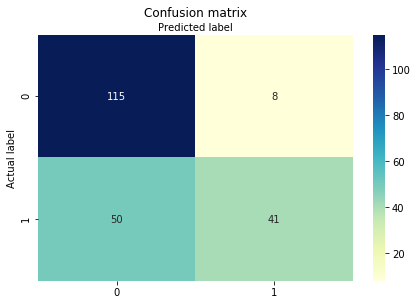

In [19]:
class_names=['Clinton', 'Kennedy'] 
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

sns.heatmap(pd.DataFrame(c_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label') 

### Logistic Regression Model

In [21]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
train = lr.fit(X_train, y_train)
print('Training set score:', lr.score(X_train, y_train))
print('\nTest set score:', lr.score(X_test, y_test))

C:\Users\rabia\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Training set score: 0.9906542056074766

Test set score: 0.8551401869158879


In [22]:
lr_score = (cross_val_score(lr, X, Y, cv=5))
print(lr_score)
print("LR Model Accuracy: %0.4f (+/- %0.4f)" % (lr_score.mean(), lr_score.std() * 2))

C:\Users\rabia\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\rabia\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\rabia\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\rabia\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\rabia\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

[0.71962617 0.85046729 0.78504673 0.8411215  0.73831776]
LR Model Accuracy: 0.7869 (+/- 0.1053)


In [23]:
y_pred = lr.predict(X_test)

c_matrix = confusion_matrix(y_test, y_pred)

Text(0.5, 257.44, 'Predicted label')

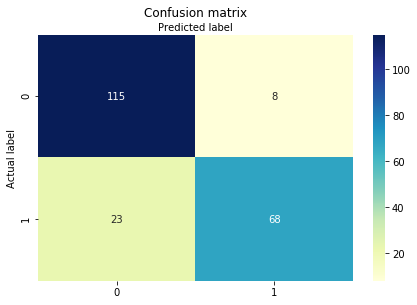

In [24]:
class_names=['Clinton', 'Kennedy'] 
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

sns.heatmap(pd.DataFrame(c_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label') 

### Gradient Boosting Model

In [25]:
clf = ensemble.GradientBoostingClassifier()
train = clf.fit(X_train, y_train)

print('Training set score:', clf.score(X_train, y_train))
print('\nTest set score:', clf.score(X_test, y_test))

Training set score: 0.956386292834891

Test set score: 0.7336448598130841


In [27]:
clf_score = (cross_val_score(clf, X, Y, cv=5))
print(clf_score)
print("CLF Model Accuracy: %0.4f (+/- %0.4f)" % (clf_score.mean(), clf_score.std() * 2))

[0.6635514  0.77570093 0.6728972  0.78504673 0.69158879]
CLF Model Accuracy: 0.7178 (+/- 0.1040)


In [30]:
y_pred = clf.predict(X_test)

c_matrix = confusion_matrix(y_test, y_pred)

Text(0.5, 257.44, 'Predicted label')

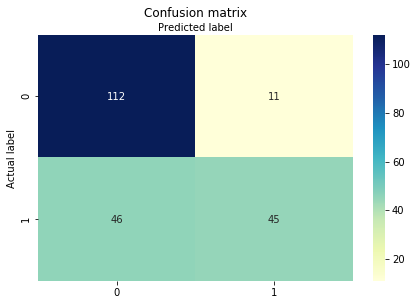

In [31]:
class_names=['Clinton', 'Kennedy'] 
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

sns.heatmap(pd.DataFrame(c_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label') 

### Support Vectore Machine Model

In [181]:
from sklearn.svm import SVC
svc = SVC()
train = svc.fit(X_train, y_train)

print('Training set score:', svc.score(X_train, y_train))
print('\nTest set score:', svc.score(X_test, y_test))

C:\Users\rabia\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Training set score: 0.5514018691588785

Test set score: 0.5747663551401869


In [182]:
svc_score = (cross_val_score(svc, X, Y, cv=5))
print(svc_score)
print("SVC Model Accuracy: %0.4f (+/- %0.4f)" % (svc_score.mean(), svc_score.std() * 2))

C:\Users\rabia\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\rabia\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\rabia\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\rabia\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarni

[0.56074766 0.56074766 0.56074766 0.56074766 0.56074766]
SVC Model Accuracy: 0.5607 (+/- 0.0000)


In [34]:
y_pred = svc.predict(X_test)

c_matrix = confusion_matrix(y_test, y_pred)

Text(0.5, 257.44, 'Predicted label')

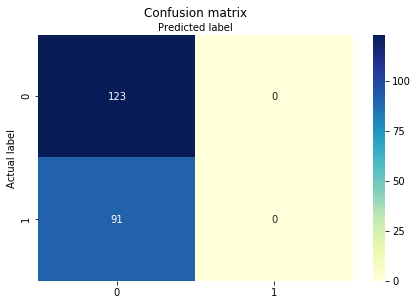

In [35]:
class_names=['Clinton', 'Kennedy'] 
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

sns.heatmap(pd.DataFrame(c_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label') 

## TF-IDF

In [36]:
# Grab sentence level documents in NLTK
clinton = state_union.sents('1993-Clinton.txt')
kennedy = state_union.sents('1961-Kennedy.txt')

In [37]:
# Create list of text 
clinton_list = [" ".join(sent) for sent in clinton]
kennedy_list = [" ".join(sent) for sent in kennedy]
joined = clinton_list + kennedy_list

In [40]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_df=0.5, 
                             min_df=2, 
                             stop_words='english',   
                             use_idf=True,
                             norm=u'l2', 
                             smooth_idf=True 
                            )

words_tfidf = vectorizer.fit_transform(joined).tocsr()

### Random Forest Model

In [41]:
X = words_tfidf
Y = ['Clinton']*len(clinton_list) + ['Kennedy']*len(kennedy_list)

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    Y,
                                                    test_size=0.4,
                                                    random_state=0)
train = rfc.fit(X_train, y_train)

print('Training set score:', rfc.score(X_train, y_train))
print('\nTest set score:', rfc.score(X_test, y_test))

Training set score: 0.9871794871794872

Test set score: 0.7980769230769231


In [42]:
from sklearn.model_selection import cross_val_score
rfc_score = (cross_val_score(rfc, X, Y, cv=5))
print(rfc_score)
print("RFC Model Accuracy: %0.4f (+/- %0.4f)" % (rfc_score.mean(), rfc_score.std() * 2))

[0.75238095 0.77142857 0.75       0.75728155 0.61165049]
RFC Model Accuracy: 0.7285 (+/- 0.1178)


In [43]:
y_pred = rfc.predict(X_test)

from sklearn.metrics import confusion_matrix
c_matrix = confusion_matrix(y_test, y_pred)

Text(0.5, 257.44, 'Predicted label')

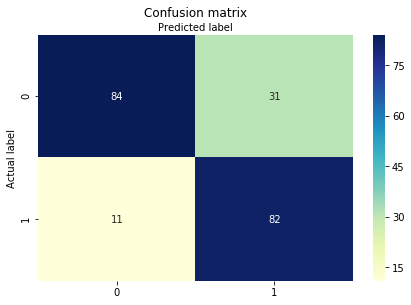

In [44]:
class_names=['Clinton', 'Kennedy'] 
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

sns.heatmap(pd.DataFrame(c_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label') 

### Logistic Regression Model

In [45]:
train = lr.fit(X_train, y_train)
print('Training set score:', lr.score(X_train, y_train))
print('\nTest set score:', lr.score(X_test, y_test))

C:\Users\rabia\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Training set score: 0.9391025641025641

Test set score: 0.8461538461538461


In [46]:
lr_score = (cross_val_score(lr, X, Y, cv=5))
print(lr_score)
print("LR Model Accuracy: %0.4f (+/- %0.4f)" % (lr_score.mean(), lr_score.std() * 2))

C:\Users\rabia\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


[0.78095238 0.83809524 0.80769231 0.84466019 0.69902913]
LR Model Accuracy: 0.7941 (+/- 0.1054)


In [47]:
y_pred = lr.predict(X_test)

c_matrix = confusion_matrix(y_test, y_pred)

Text(0.5, 257.44, 'Predicted label')

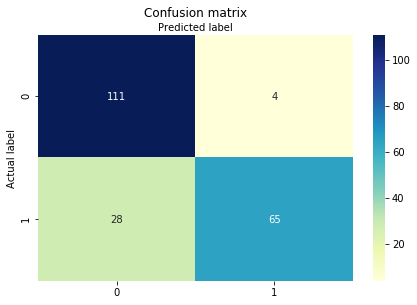

In [48]:
class_names=['Clinton', 'Kennedy'] 
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

sns.heatmap(pd.DataFrame(c_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label') 

### Gradient Boosting Model

In [49]:
train = clf.fit(X_train, y_train)

print('Training set score:', clf.score(X_train, y_train))
print('\nTest set score:', clf.score(X_test, y_test))

Training set score: 0.9423076923076923

Test set score: 0.7451923076923077


In [50]:
clf_score = (cross_val_score(clf, X, Y, cv=5))
print(clf_score)
print("CLF Model Accuracy: %0.4f (+/- %0.4f)" % (clf_score.mean(), clf_score.std() * 2))

[0.66666667 0.7047619  0.68269231 0.7961165  0.68932039]
CLF Model Accuracy: 0.7079 (+/- 0.0915)


In [51]:
y_pred = clf.predict(X_test)

c_matrix = confusion_matrix(y_test, y_pred)

Text(0.5, 257.44, 'Predicted label')

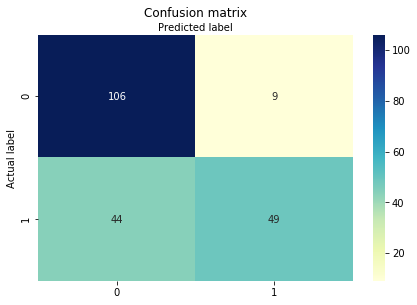

In [52]:
class_names=['Clinton', 'Kennedy'] 
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

sns.heatmap(pd.DataFrame(c_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label') 

### Support Vector Machine Model

In [53]:
train = svc.fit(X_train, y_train)

print('Training set score:', svc.score(X_train, y_train))
print('\nTest set score:', svc.score(X_test, y_test))

C:\Users\rabia\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Training set score: 0.5673076923076923

Test set score: 0.5528846153846154


In [179]:
svc_score = (cross_val_score(svc, X, Y, cv=5))
print(svc_score)
print("SVC Model Accuracy: %0.4f (+/- %0.4f)" % (svc_score.mean(), svc_score.std() * 2))

C:\Users\rabia\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


[0.56190476 0.56190476 0.55769231 0.5631068  0.5631068 ]
SVC Model Accuracy: 0.5615 (+/- 0.0040)


In [55]:
y_pred = svc.predict(X_test)

c_matrix = confusion_matrix(y_test, y_pred)

Text(0.5, 257.44, 'Predicted label')

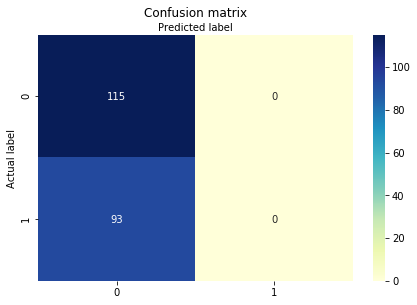

In [56]:
class_names=['Clinton', 'Kennedy'] 
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

sns.heatmap(pd.DataFrame(c_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label') 

Best possible model is TF-IDF logistic regression model. In the next lines of code, I will try to tune the model and increase the accuracy of the model above the average of 0.79

### Model Tunning

min_df increased from 2 to 3, and lower case has been disabled

In [172]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_df=0.5, 
                             min_df=3, 
                             stop_words='english',   
                             use_idf=True,
                             norm=u'l2', 
                             smooth_idf= True,
                             lowercase = False,
                            )

words_tfidf = vectorizer.fit_transform(joined).tocsr()

In [173]:
X = words_tfidf
Y = ['Clinton']*len(clinton_list) + ['Kennedy']*len(kennedy_list)

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    Y,
                                                    test_size=0.4,
                                                    random_state=0)

train = lr.fit(X_train, y_train)
print('Training set score:', lr.score(X_train, y_train))
print('\nTest set score:', lr.score(X_test, y_test))

Training set score: 0.9519230769230769

Test set score: 0.8125


In [174]:
lr_score = (cross_val_score(lr, X, Y, cv=5))
print(lr_score)
print("LR Model Accuracy: %0.4f (+/- %0.4f)" % (lr_score.mean(), lr_score.std() * 2))

C:\Users\rabia\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


[0.8        0.81904762 0.84615385 0.87378641 0.77669903]
LR Model Accuracy: 0.8231 (+/- 0.0681)


These changes helped in increasing the average accuracy of the model from 0.79 to 0.82. <br>
Below, I will try to tune the logistic regression model parameters to get the best possible accuracy.

In [175]:
#Try optimizing the LR model
from sklearn.model_selection import GridSearchCV
tuned_parameters = [{'penalty': ['l1', 'l2'],
                     'class_weight': ['balanced', None],
                     'C': [0.1, 1 ,10, 100, 1000],
                    }]
 
gscv = GridSearchCV(estimator = LogisticRegression(), param_grid = tuned_parameters, cv = 5, n_jobs = -1)
gscv.fit(X_train, y_train)
gscv.best_params_

C:\Users\rabia\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\rabia\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


{'C': 0.1, 'class_weight': 'balanced', 'penalty': 'l2'}

c will be changed from 1.0 (default) to 0.1, class weight will be changed from  None to 'balanced', and no change for penalty since penalty = 'l2' is the default.

In [177]:
lr = LogisticRegression(C = 0.1, class_weight = 'balanced')
train = lr.fit(X_train, y_train)
print('Training set score:', lr.score(X_train, y_train))
print('\nTest set score:', lr.score(X_test, y_test))

Training set score: 0.9487179487179487

Test set score: 0.8701923076923077


In [178]:
lr_score = (cross_val_score(lr, X, Y, cv=5))
print(lr_score)
print("LR Model Accuracy: %0.4f (+/- %0.4f)" % (lr_score.mean(), lr_score.std() * 2))

C:\Users\rabia\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


[0.75238095 0.88571429 0.82692308 0.89320388 0.76699029]
LR Model Accuracy: 0.8250 (+/- 0.1166)


The accuracy score slightly increaed to 0.825.